In [30]:
from diffusion_reaction import DiffReactNN

import torch
import torchopt
from tqdm import tqdm

In [31]:
from torch.func import functional_call, grad, vmap
from torch import nn

from collections import OrderedDict
from typing import Callable

from utils import tuple_2_dict
from pdes import inversed_k, inversed_u    

In [32]:
def make_fwd_inv_fn(model: nn.Module):

    def fn(x: torch.Tensor, params: dict[str, nn.Parameter] | tuple[nn.Parameter]) -> Callable:
        if isinstance(params, tuple):
            params_dict = tuple_2_dict(model, params)
        else:
            params_dict = params  

        return functional_call(model, params_dict, (x, )).squeeze()
    
    return fn

In [33]:
#Let's define the differentiable part of the the function u(x)
def u_diff(x, params):
    return fn(x, params)[0]

#Defining the first derivative w.r.t. x (note that it is not vmapped since it will be used by the second derivative)
def dudx(x: torch.Tensor, params: torch.Tensor):
    return grad(u_diff)(x, params).squeeze()

def dudx_v(x: torch.Tensor, params: torch.Tensor):
    return vmap(dudx, in_dims=(0, None))(x, params).squeeze()

#Defining the second derivative w.r.t. x
def d2udx2(x: torch.Tensor, params: torch.Tensor):
    return vmap(grad(dudx), in_dims=(0, None))(x, params).squeeze()

In [34]:
#Data to initialize
x_domain = (0, 1)
learning_rate = 0.01
n_epochs = 1000
batch_size = 20

In [35]:
#Model setup
diff_react_model = DiffReactNN()
params = tuple(diff_react_model.parameters())

In [36]:
fn = make_fwd_inv_fn(diff_react_model)

In [37]:
x = torch.FloatTensor(batch_size, 1).uniform_(x_domain[0], x_domain[1])

In [89]:
def make_diff_react_loss(fn: Callable) -> Callable:
    
    #This is the standard forward function
    def u(x: torch.Tensor, params: dict[str, nn.Parameter] | tuple[nn.Parameter]) -> Callable:
        return fn(x, params)[:, 0].squeeze() #Take the first entry
    
    #This is the target inverse function (related to the raction coefficient)
    def k(x: torch.Tensor, params: dict[str, nn.Parameter] | tuple[nn.Parameter]) -> Callable:
        return fn(x, params)[:, 1].squeeze() #Take the second entry

    def diff_react_loss(x: torch.Tensor, params: torch.Tensor):
        loss = nn.MSELoss()
        u_value = u(x, params)
        real_u_value = inversed_u(x)
        k_value = k(x, params)
        real_k_value = inversed_k(x)
        print(f"u_value:{u_value.dtype}, real_u_value: {real_u_value.dtype}, k_value:{k_value.dtype}, real_k_value: {real_k_value.dtype}")
        data_loss = loss(u_value, real_u_value) + loss(k_value, real_k_value)
        data_loss = data_loss
        f_value = torch.sin(2 * torch.pi * x).squeeze() + k(x, params) * u(x, params) - 0.01 * d2udx2(x, params)
        physics_loss = loss(f_value, torch.zeros_like(f_value))
        return data_loss + physics_loss

    return diff_react_loss

In [90]:
diff_react_loss = make_diff_react_loss(fn)

In [91]:
diff_react_loss(x, params)

u_value:torch.float32, real_u_value: torch.float64, k_value:torch.float32, real_k_value: torch.float32


tensor(0.0263, dtype=torch.float64, grad_fn=<AddBackward0>)

In [82]:
result = fn(x, params)

In [83]:
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

In [84]:
#Defining the training process
loss_evolution = []

for epoch in tqdm(range(n_epochs)):
    #Let's start with a uniform distribution of the data 
    x = torch.FloatTensor(batch_size, 1).uniform_(x_domain[0], x_domain[1])
    #We compute the loss
    loss = diff_react_loss(x, params)
    #Update the parameters with the functional optimizer
    params = optimizer.step(loss, params)
    #Keeping track of the loss
    loss_evolution.append(float(loss))

  1%|          | 9/1000 [00:00<00:22, 44.58it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


  2%|▏         | 15/1000 [00:00<00:20, 47.66it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


  3%|▎         | 26/1000 [00:00<00:20, 46.52it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


  4%|▎         | 36/1000 [00:00<00:21, 45.39it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


  5%|▍         | 47/1000 [00:01<00:19, 47.88it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


  6%|▌         | 58/1000 [00:01<00:19, 49.27it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


  7%|▋         | 69/1000 [00:01<00:18, 50.74it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


  8%|▊         | 75/1000 [00:01<00:18, 50.70it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


  9%|▊         | 86/1000 [00:01<00:25, 36.20it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 10%|▉         | 99/1000 [00:02<00:20, 44.27it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 11%|█         | 112/1000 [00:02<00:18, 48.41it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 12%|█▏        | 118/1000 [00:02<00:18, 47.13it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 13%|█▎        | 130/1000 [00:02<00:19, 43.52it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 14%|█▎        | 136/1000 [00:02<00:18, 46.37it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 15%|█▍        | 147/1000 [00:03<00:18, 46.93it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 16%|█▌        | 160/1000 [00:03<00:18, 46.25it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 17%|█▋        | 172/1000 [00:03<00:16, 50.80it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 18%|█▊        | 178/1000 [00:03<00:16, 50.78it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 19%|█▉        | 190/1000 [00:04<00:16, 49.30it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 20%|█▉        | 196/1000 [00:04<00:15, 51.13it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 20%|██        | 202/1000 [00:04<00:23, 33.29it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 21%|██        | 212/1000 [00:04<00:21, 37.48it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 22%|██▎       | 225/1000 [00:04<00:16, 45.70it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 24%|██▍       | 238/1000 [00:05<00:14, 51.05it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 25%|██▌       | 250/1000 [00:05<00:14, 51.68it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 26%|██▌       | 256/1000 [00:05<00:14, 50.46it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 27%|██▋       | 268/1000 [00:05<00:14, 50.06it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 28%|██▊       | 280/1000 [00:06<00:14, 49.65it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 29%|██▊       | 286/1000 [00:06<00:15, 46.71it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 30%|██▉       | 297/1000 [00:06<00:14, 48.69it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 31%|███       | 307/1000 [00:06<00:16, 41.00it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 31%|███       | 312/1000 [00:06<00:16, 42.41it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 32%|███▏      | 321/1000 [00:07<00:20, 33.03it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 33%|███▎      | 332/1000 [00:07<00:16, 39.75it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 34%|███▎      | 337/1000 [00:07<00:15, 41.58it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 34%|███▍      | 342/1000 [00:07<00:22, 29.52it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 35%|███▍      | 346/1000 [00:07<00:24, 26.59it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 35%|███▌      | 354/1000 [00:08<00:25, 25.23it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 36%|███▌      | 358/1000 [00:08<00:23, 26.80it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 36%|███▋      | 363/1000 [00:08<00:20, 31.22it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 37%|███▋      | 372/1000 [00:08<00:25, 24.63it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 38%|███▊      | 375/1000 [00:09<00:27, 22.60it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 38%|███▊      | 383/1000 [00:09<00:22, 27.19it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 39%|███▊      | 387/1000 [00:09<00:29, 21.02it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 39%|███▉      | 390/1000 [00:09<00:33, 18.07it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 40%|███▉      | 396/1000 [00:10<00:31, 18.88it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 40%|████      | 404/1000 [00:10<00:22, 25.95it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 42%|████▏     | 415/1000 [00:10<00:15, 36.75it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 42%|████▏     | 420/1000 [00:10<00:14, 38.81it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 43%|████▎     | 429/1000 [00:11<00:15, 37.26it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 44%|████▍     | 440/1000 [00:11<00:13, 42.02it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 44%|████▍     | 445/1000 [00:11<00:13, 41.95it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 46%|████▌     | 455/1000 [00:12<00:21, 25.56it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 46%|████▌     | 461/1000 [00:12<00:17, 31.18it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 47%|████▋     | 470/1000 [00:12<00:18, 28.55it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 48%|████▊     | 479/1000 [00:12<00:16, 31.82it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 48%|████▊     | 485/1000 [00:12<00:13, 37.34it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 50%|████▉     | 495/1000 [00:13<00:13, 38.21it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 51%|█████     | 507/1000 [00:13<00:11, 44.45it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 51%|█████     | 512/1000 [00:13<00:11, 42.66it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 52%|█████▏    | 521/1000 [00:13<00:12, 37.06it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 53%|█████▎    | 532/1000 [00:13<00:10, 44.08it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 54%|█████▍    | 542/1000 [00:14<00:10, 44.20it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 55%|█████▌    | 552/1000 [00:14<00:09, 45.79it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 56%|█████▌    | 561/1000 [00:14<00:13, 33.16it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 57%|█████▋    | 573/1000 [00:14<00:10, 39.78it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 58%|█████▊    | 583/1000 [00:15<00:10, 40.29it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 60%|█████▉    | 595/1000 [00:15<00:08, 47.36it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 60%|██████    | 600/1000 [00:15<00:08, 46.29it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 61%|██████    | 610/1000 [00:15<00:08, 47.00it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 62%|██████▏   | 621/1000 [00:15<00:07, 49.21it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 63%|██████▎   | 634/1000 [00:16<00:07, 47.08it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 65%|██████▍   | 646/1000 [00:16<00:06, 51.14it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 65%|██████▌   | 652/1000 [00:16<00:06, 50.06it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 66%|██████▌   | 658/1000 [00:16<00:07, 46.31it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 66%|██████▋   | 663/1000 [00:17<00:10, 30.89it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 67%|██████▋   | 671/1000 [00:17<00:10, 31.47it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 68%|██████▊   | 683/1000 [00:17<00:07, 39.70it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 69%|██████▉   | 693/1000 [00:17<00:07, 41.14it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 70%|██████▉   | 699/1000 [00:17<00:06, 43.15it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 71%|███████   | 710/1000 [00:18<00:06, 47.25it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 72%|███████▏  | 723/1000 [00:18<00:05, 46.97it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 73%|███████▎  | 734/1000 [00:18<00:05, 47.23it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 74%|███████▍  | 739/1000 [00:18<00:05, 46.70it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 75%|███████▍  | 749/1000 [00:18<00:05, 43.81it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 76%|███████▌  | 755/1000 [00:19<00:05, 44.36it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 76%|███████▌  | 760/1000 [00:19<00:08, 26.79it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 77%|███████▋  | 769/1000 [00:19<00:07, 31.73it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 78%|███████▊  | 781/1000 [00:19<00:05, 40.29it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 79%|███████▊  | 786/1000 [00:20<00:05, 40.89it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 80%|███████▉  | 797/1000 [00:20<00:04, 45.25it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 81%|████████  | 808/1000 [00:20<00:04, 41.13it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 81%|████████▏ | 813/1000 [00:20<00:04, 41.11it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 82%|████████▏ | 823/1000 [00:20<00:04, 43.95it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 84%|████████▎ | 836/1000 [00:21<00:03, 44.51it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 84%|████████▍ | 842/1000 [00:21<00:03, 46.41it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 85%|████████▍ | 847/1000 [00:21<00:04, 37.38it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 85%|████████▌ | 852/1000 [00:21<00:05, 26.66it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 86%|████████▌ | 860/1000 [00:22<00:04, 29.11it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 87%|████████▋ | 870/1000 [00:22<00:03, 35.96it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 88%|████████▊ | 881/1000 [00:22<00:02, 41.25it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 89%|████████▉ | 892/1000 [00:22<00:02, 46.06it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 90%|████████▉ | 897/1000 [00:22<00:02, 46.37it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 91%|█████████ | 908/1000 [00:23<00:02, 45.23it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 92%|█████████▏| 921/1000 [00:23<00:01, 47.02it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 93%|█████████▎| 926/1000 [00:23<00:01, 42.79it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 94%|█████████▎| 935/1000 [00:23<00:01, 34.85it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 94%|█████████▍| 943/1000 [00:24<00:02, 27.68it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 95%|█████████▌| 954/1000 [00:24<00:01, 36.15it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 96%|█████████▋| 965/1000 [00:24<00:00, 42.45it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 98%|█████████▊| 977/1000 [00:24<00:00, 48.40it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


 98%|█████████▊| 983/1000 [00:24<00:00, 48.43it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


 99%|█████████▉| 993/1000 [00:25<00:00, 43.61it/s]

torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32


100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]

Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32
torch.float32
Loss type: torch.float32


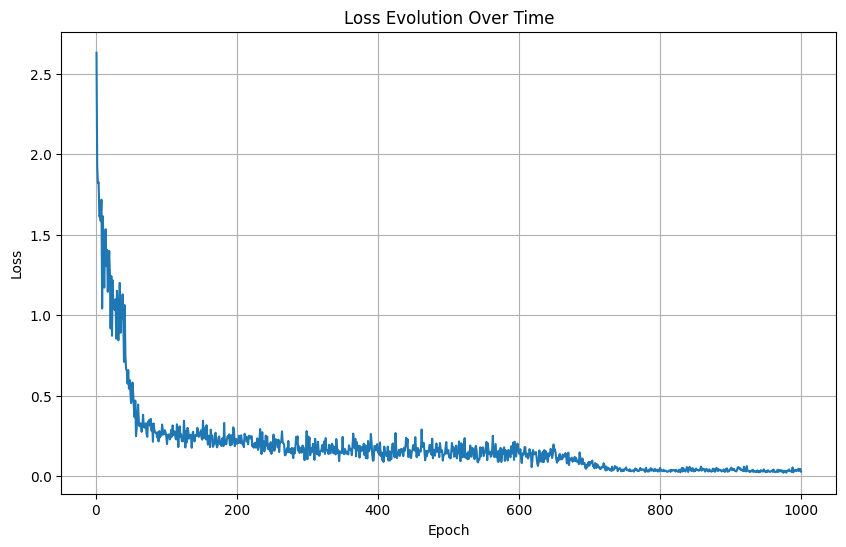

In [85]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), loss_evolution, linestyle='-')
plt.title('Loss Evolution Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()